# Bitcoin Price Forecasting with TimeGPT

## Introduction

Bitcoin price forecasting is crucial for:
- Understanding market trends and volatility
- Risk management in cryptocurrency trading
- Portfolio optimization
- Investment strategy development

This notebook demonstrates how to use TimeGPT for Bitcoin price forecasting using synthetic data. While real cryptocurrency prices are highly volatile and challenging to predict, this example shows how TimeGPT can be used to model and forecast time series with complex patterns similar to those found in crypto markets.

## Setup

First, let's install and import the required packages.

In [1]:
%%capture
!pip install nixtla pandas numpy matplotlib seaborn utilsforecast

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse, smape
from utilsforecast.evaluation import evaluate

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [15, 6]

# Initialize Nixtla client
nixtla_client = NixtlaClient(
    api_key='nixak-YdxgHOqWIumbzuaM3A4FiCAaIBp6NLVstE1CjJEnN2Ia9Lu0k6lttUxmz4LZtBNTNV8bYf3owJy6btvb'
)

print("✅ Setup completed successfully")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


✅ Setup completed successfully


## Synthetic Bitcoin Price Generation

We'll create synthetic Bitcoin price data that incorporates typical cryptocurrency market patterns:
- Long-term growth trend
- Periodic volatility cycles
- Random market shocks
- Sudden price spikes and drops
- Daily price variations

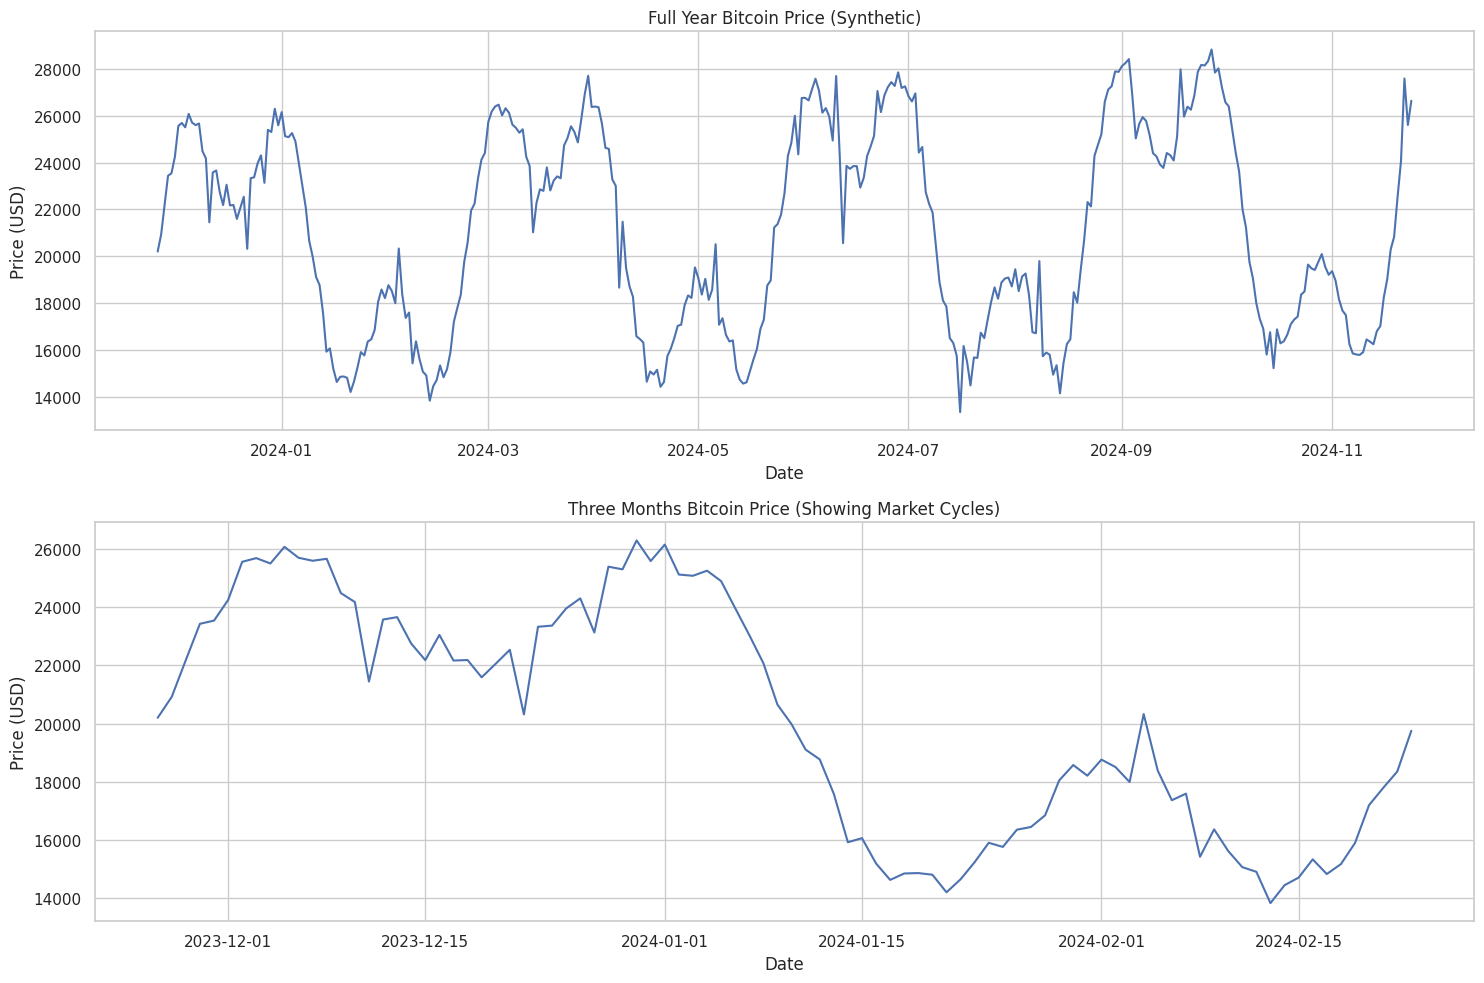


Price Statistics:
Average Price: $21117.61
Price Range: $13336.79 - $28832.09
Daily Volatility: 5.32%
Number of significant price shocks: 91


In [3]:
def generate_bitcoin_prices(days=365, start_price=20000):
    """
    Generate synthetic daily Bitcoin price data.

    Parameters:
    -----------
    days : int
        Number of days of data to generate
    start_price : float
        Initial Bitcoin price in USD

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: unique_id, ds, y
    """
    # Generate timestamps
    end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    start_date = end_date - timedelta(days=days-1)
    timestamps = pd.date_range(start=start_date, end=end_date, freq='D')

    # Generate components
    t = np.arange(days)

    # 1. Long-term growth trend (exponential)
    growth_rate = 0.0003  # Small daily growth rate
    trend = start_price * np.exp(growth_rate * t)

    # 2. Market cycles (multiple periodic components)
    short_cycle = 0.15 * trend * np.sin(2 * np.pi * t / 30)   # 30-day cycle
    medium_cycle = 0.25 * trend * np.sin(2 * np.pi * t / 90)  # 90-day cycle

    # 3. Volatility (varies with price level)
    volatility = 0.02 * trend  # 2% of price level
    daily_noise = np.random.normal(0, 1, days) * volatility

    # 4. Market shocks (sudden price changes)
    n_shocks = int(days * 0.05)  # 5% of days have shocks
    shock_indices = np.random.choice(days, n_shocks, replace=False)
    shocks = np.zeros(days)

    for idx in shock_indices:
        # Shock magnitude varies with price level
        magnitude = np.random.uniform(0.05, 0.15) * trend[idx]  # 5-15% of price
        if np.random.random() < 0.5:  # 50% chance of negative shock
            magnitude *= -1
        shocks[idx] = magnitude

    # Combine all components
    price = trend + short_cycle + medium_cycle + daily_noise + shocks

    # Ensure no negative prices
    price = np.maximum(price, 100)  # Minimum price of $100

    # Create DataFrame
    df = pd.DataFrame({
        'unique_id': 'BTC-USD',
        'ds': timestamps,
        'y': price
    })

    return df

# Generate dataset
df = generate_bitcoin_prices()

# Plot the data
plt.figure(figsize=(15, 10))

# Plot full time series
plt.subplot(2, 1, 1)
plt.plot(df['ds'], df['y'])
plt.title('Full Year Bitcoin Price (Synthetic)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

# Plot three months of data to show cycles
three_months = df.iloc[:90]
plt.subplot(2, 1, 2)
plt.plot(three_months['ds'], three_months['y'])
plt.title('Three Months Bitcoin Price (Showing Market Cycles)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')

plt.tight_layout()
plt.show()

# Calculate some statistics
returns = df['y'].pct_change().dropna()
print("\nPrice Statistics:")
print(f"Average Price: ${df['y'].mean():.2f}")
print(f"Price Range: ${df['y'].min():.2f} - ${df['y'].max():.2f}")
print(f"Daily Volatility: {returns.std() * 100:.2f}%")
print(f"Number of significant price shocks: {len(returns[abs(returns) > 0.05])}")

## Bitcoin Price Forecasting

Now we'll use TimeGPT to forecast Bitcoin prices for the next 30 days. We'll:
1. Split the data into training and test sets
2. Generate forecasts with confidence intervals
3. Evaluate the model's performance

Training data: 335 days
Test data: 30 days

Forecast Evaluation Metrics:


,unique_id,metric,TimeGPT
0,BTC-USD,mae,2.574460e+03
1,BTC-USD,mse,9.852022e+06
2,BTC-USD,smape,6.542650e-02



Mean Absolute Percentage Error: 13.87%


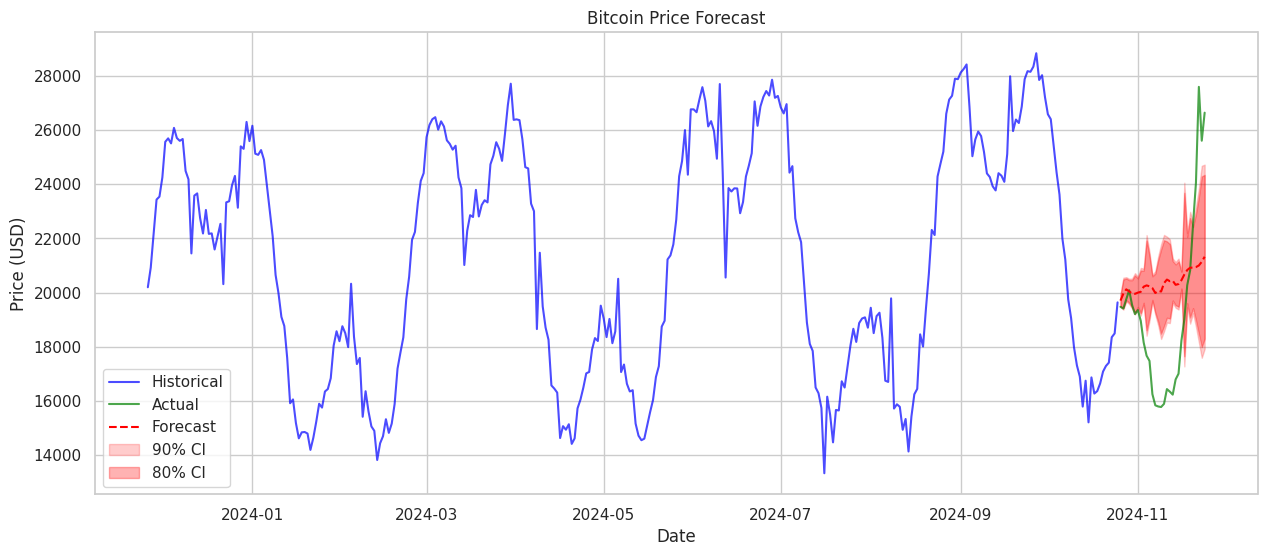

In [4]:
# Split data into train and test
test_days = 30  # 30 days for testing
train_df = df.iloc[:-test_days].copy()
test_df = df.iloc[-test_days:].copy()

print(f"Training data: {len(train_df)} days")
print(f"Test data: {len(test_df)} days")

# Generate forecasts
fcst_df = nixtla_client.forecast(
    df=train_df,
    h=test_days,
    level=[80, 90],  # Generate 80% and 90% confidence intervals
    freq='D',
    finetune_steps=10,  # Fine-tune the model
    finetune_loss='mae',  # Use MAE as the loss function
    model='timegpt-1-long-horizon',  # Use long-horizon model for multi-day forecasts
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

# Evaluate forecasts
evaluation_df = pd.merge(test_df, fcst_df, on=['unique_id', 'ds'], how='left')

metrics = evaluate(
    evaluation_df,
    metrics=[mae, mse, smape],
    models=['TimeGPT'],
    target_col='y',
    id_col='unique_id'
)

print("\nForecast Evaluation Metrics:")
display(metrics)

# Calculate percentage errors
mape = np.mean(np.abs((evaluation_df['y'] - evaluation_df['TimeGPT']) / evaluation_df['y'])) * 100
print(f"\nMean Absolute Percentage Error: {mape:.2f}%")

# Plot results
plt.figure(figsize=(15, 6))

# Plot historical data
plt.plot(train_df['ds'], train_df['y'],
         label='Historical', color='blue', alpha=0.7)

# Plot test data
plt.plot(test_df['ds'], test_df['y'],
         label='Actual', color='green', alpha=0.7)

# Plot forecast
plt.plot(fcst_df['ds'], fcst_df['TimeGPT'],
         label='Forecast', color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(fcst_df['ds'],
                 fcst_df['TimeGPT-lo-90'],
                 fcst_df['TimeGPT-hi-90'],
                 alpha=0.2,
                 color='red',
                 label='90% CI')

plt.fill_between(fcst_df['ds'],
                 fcst_df['TimeGPT-lo-80'],
                 fcst_df['TimeGPT-hi-80'],
                 alpha=0.3,
                 color='red',
                 label='80% CI')

plt.title('Bitcoin Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

## Analysis of Forecast Uncertainty

Let's analyze how the forecast uncertainty changes over time and its relationship with price levels.

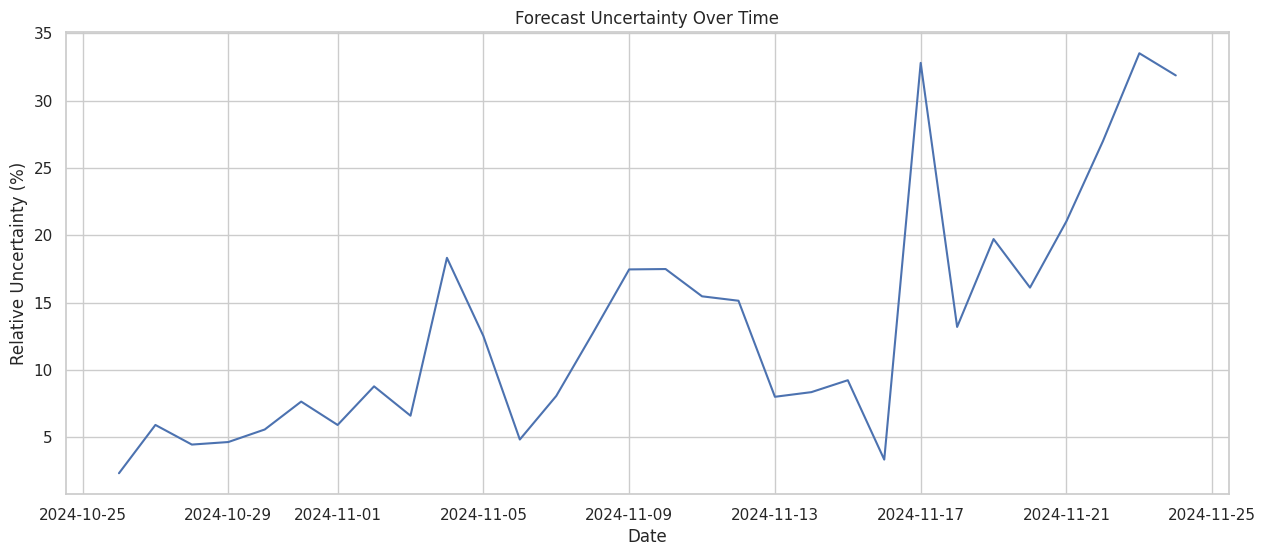


Uncertainty Analysis:
Average 90% CI Width: $2732.61
Average Relative Uncertainty: 13.27%
Maximum Relative Uncertainty: 33.51%


In [5]:
# Calculate forecast uncertainty
fcst_df['uncertainty_90'] = fcst_df['TimeGPT-hi-90'] - fcst_df['TimeGPT-lo-90']
fcst_df['uncertainty_80'] = fcst_df['TimeGPT-hi-80'] - fcst_df['TimeGPT-lo-80']
fcst_df['relative_uncertainty'] = fcst_df['uncertainty_90'] / fcst_df['TimeGPT'] * 100

# Plot uncertainty over time
plt.figure(figsize=(15, 6))
plt.plot(fcst_df['ds'], fcst_df['relative_uncertainty'])
plt.title('Forecast Uncertainty Over Time')
plt.xlabel('Date')
plt.ylabel('Relative Uncertainty (%)')
plt.grid(True)
plt.show()

print("\nUncertainty Analysis:")
print(f"Average 90% CI Width: ${fcst_df['uncertainty_90'].mean():.2f}")
print(f"Average Relative Uncertainty: {fcst_df['relative_uncertainty'].mean():.2f}%")
print(f"Maximum Relative Uncertainty: {fcst_df['relative_uncertainty'].max():.2f}%")

## Conclusion

This notebook demonstrated TimeGPT's capabilities for Bitcoin price forecasting using synthetic data:

1. We generated synthetic Bitcoin price data incorporating:
   - Long-term growth trends
   - Market cycles (30-day and 90-day periods)
   - Price-dependent volatility
   - Random market shocks

2. Used TimeGPT to generate 30-day forecasts with:
   - 80% and 90% confidence intervals
   - Fine-tuning for improved accuracy

3. Evaluated the forecasts using multiple metrics:
   - Mean Absolute Error (MAE)
   - Mean Squared Error (MSE)
   - Symmetric Mean Absolute Percentage Error (sMAPE)

4. Analyzed forecast uncertainty and its relationship with price levels

Key findings:
- TimeGPT effectively captured both trend and cyclical patterns in the synthetic data
- The model's confidence intervals widened during periods of higher volatility
- Forecast uncertainty increased with the forecast horizon

For real-world applications:
- Consider incorporating external factors (market sentiment, trading volume, etc.)
- Be aware that actual cryptocurrency prices are more volatile and unpredictable
- Use confidence intervals to understand the range of possible outcomes
- Regularly update and retrain the model with new data